In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda")  # torch.device('cpu')
device

device(type='cuda')

In [3]:
rng = np.random.default_rng(73512)

## Dane syntetyczne

In [4]:
indices = np.arange(0, 50, 0.02)
synthetic_data = (
    np.sin(indices * 3) + indices / 10 + (indices / 10) ** 2 + np.sin(indices * 10)
)  # / np.exp(indices / 20)

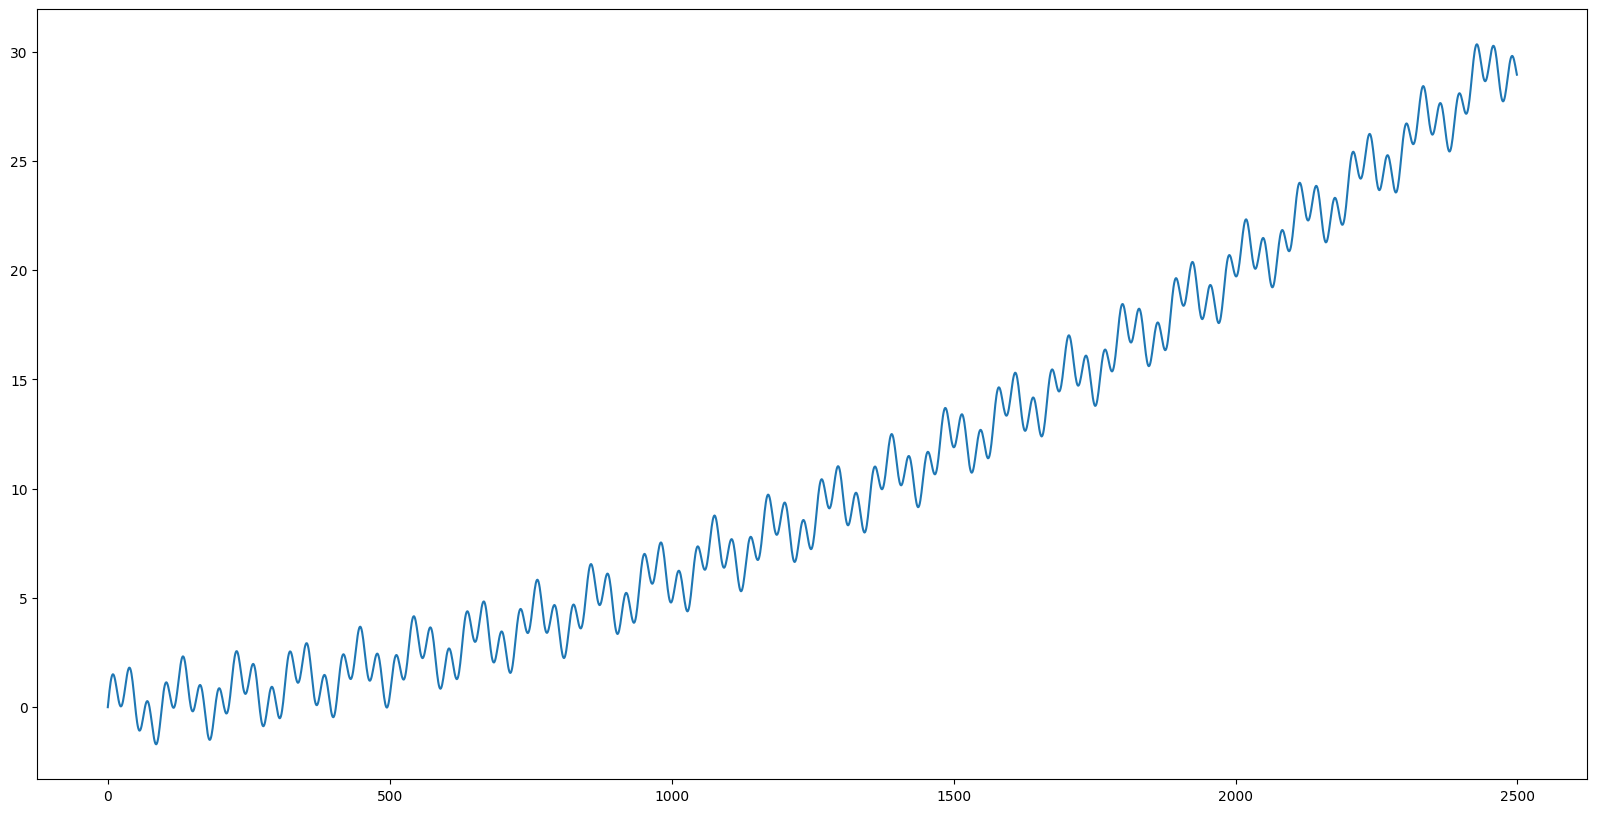

In [5]:
plt.figure(figsize=[20, 10])
plt.plot(synthetic_data)
plt.show()

In [6]:
min_value = synthetic_data.min()
max_value = synthetic_data.max()

In [7]:
data_seq = []
data_targets = []
sequence_len = 150
for i in range(len(synthetic_data) - sequence_len - 1):
    data_seq.append(torch.from_numpy(synthetic_data[i : i + sequence_len]))
    data_targets.append(synthetic_data[i + sequence_len + 1])

In [8]:
data = (torch.stack(data_seq).float() - min_value) / max_value
data_targets = (torch.Tensor(data_targets).float() - min_value) / max_value
train_indices = rng.random(len(data_seq)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(
    data[train_indices], data_targets[train_indices]
)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_data, test_targets = data[test_indices], data_targets[test_indices]

In [9]:
class SimpleRegressor(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x


model = SimpleRegressor(sequence_len, 5, 1).to(device)
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [11]:
model.train()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1)

        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00153
Epoch: 10, loss: 0.000222
Epoch: 20, loss: 0.000446
Epoch: 30, loss: 0.000216
Epoch: 40, loss: 0.000214
Epoch: 50, loss: 9.84e-05
Epoch: 60, loss: 0.000224
Epoch: 70, loss: 8.06e-05
Epoch: 80, loss: 1.49e-05
Epoch: 90, loss: 2.26e-05
Epoch: 100, loss: 3.56e-05


In [12]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.0087, device='cuda:0')


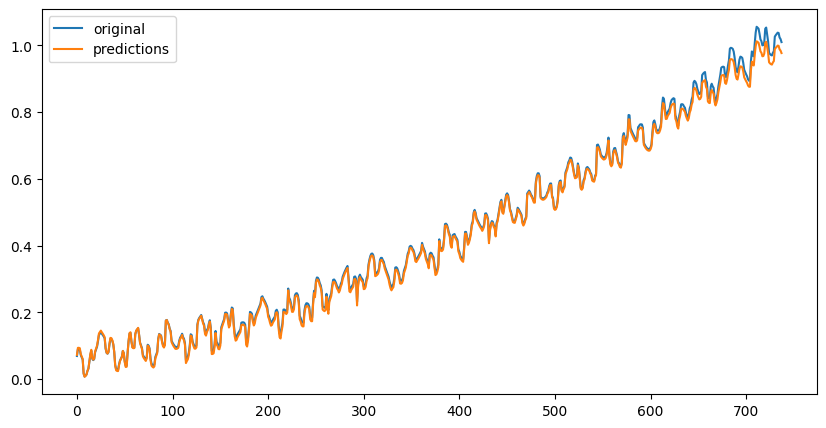

In [13]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label="original")
plt.plot(test_preds.cpu().numpy(), label="predictions")
plt.legend()
plt.show()

### Co jest nie tak?

In [14]:
train_split = int(len(data) * 0.6)
train_set = torch.utils.data.TensorDataset(
    data[:train_split], data_targets[:train_split]
)
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [15]:
model = SimpleRegressor(sequence_len, 5, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1)

        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00148
Epoch: 10, loss: 4.29e-05
Epoch: 20, loss: 0.000138
Epoch: 30, loss: 0.000104
Epoch: 40, loss: 9.61e-05
Epoch: 50, loss: 7.18e-05
Epoch: 60, loss: 4.65e-05
Epoch: 70, loss: 7.52e-05
Epoch: 80, loss: 4.39e-05
Epoch: 90, loss: 1.93e-05
Epoch: 100, loss: 2.33e-05


In [16]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.1294, device='cuda:0')


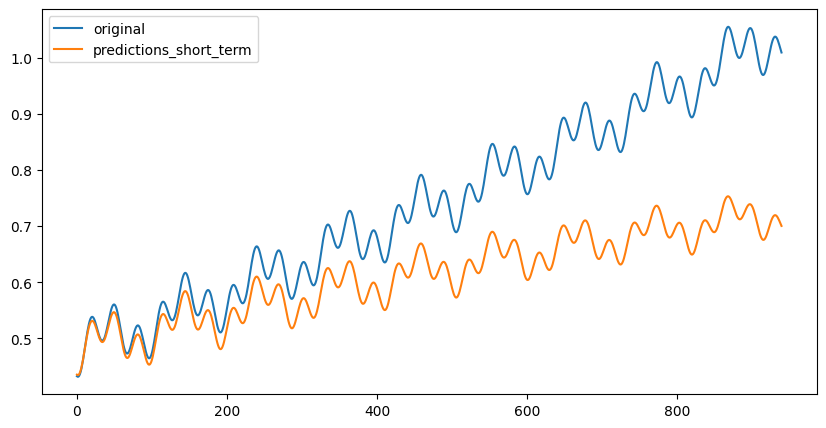

In [17]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label="original")
plt.plot(test_preds.cpu().numpy(), label="predictions_short_term")
plt.legend()
plt.show()

## Sieć rekurencyjna
![](https://cdn.jsdelivr.net/gh/AuthurWhywait/images/20211202145041.png)
![](https://cdn.jsdelivr.net/gh/AuthurWhywait/images/20211202151931.png)

### Podaj odpowiednie rozmiary macierzy

In [21]:
class RecurrentRegressor(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.act_fn = nn.Tanh()
        self.linear_xh = nn.Linear(num_inputs, num_hidden)
        self.linear_hh = nn.Linear(num_hidden, num_hidden)
        self.linear_hy = nn.Linear(num_hidden, num_outputs)

    def forward(self, x, state):
        h = self.act_fn(self.linear_hh(state) + self.linear_xh(x))
        y = self.linear_hy(h)
        return y, h


HIDDEN_SIZE = 5
model = RecurrentRegressor(1, HIDDEN_SIZE, 1).to(device)
model

RecurrentRegressor(
  (act_fn): Tanh()
  (linear_xh): Linear(in_features=1, out_features=5, bias=True)
  (linear_hh): Linear(in_features=5, out_features=5, bias=True)
  (linear_hy): Linear(in_features=5, out_features=1, bias=True)
)

### Dokończ pętlę uczącą poniżej:

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        loss_total = 0
        state = torch.zeros(len(x), HIDDEN_SIZE).to(device)
        optimizer.zero_grad()
        for i in range(x.size(1)):
            x_one = x[:, i].unsqueeze(1)
            if i < sequence_len - 1:
              target = x[:, i + 1]
            else:
              target = targets
            preds, state = model(x_one, state)
            preds = preds.squeeze(dim=1)
            loss = loss_fun(preds, target)
            loss_total += loss
        loss_total.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0098
Epoch: 10, loss: 0.00131
Epoch: 20, loss: 0.000507
Epoch: 30, loss: 0.000292
Epoch: 40, loss: 0.000195
Epoch: 50, loss: 0.000152
Epoch: 60, loss: 0.000129
Epoch: 70, loss: 0.000114
Epoch: 80, loss: 0.000103
Epoch: 90, loss: 9.44e-05
Epoch: 100, loss: 8.55e-05


In [23]:
with torch.no_grad():
    state = torch.zeros(len(test_data), HIDDEN_SIZE).to(device)
    test_preds = []
    for i in range(test_data.size(1)):
        x_one = test_data[:, i].unsqueeze(1).to(device)
        preds, state = model(x_one, state)
    test_preds.append(preds)
    print(torch.abs((torch.cat(test_preds).squeeze() - test_targets.to(device))).mean())

tensor(0.0700, device='cuda:0')


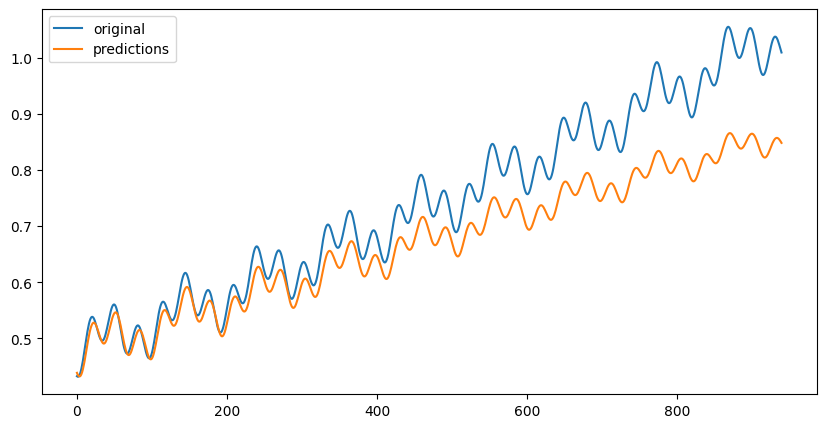

In [24]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label="original")
plt.plot(torch.cat(test_preds).squeeze().cpu().numpy(), label="predictions")
plt.legend()
plt.show()

## Sieci rekurencyjne w Torchu

https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html

In [25]:
BATCH_SIZE = 2
INPUT_SIZE = 3
NUM_LAYERS = 1 # najczesciej przy trudniejszych problemów używa się większej ilości
rnn = nn.RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    batch_first=False,
)  # batch_first=False is default!!
rnn

RNN(3, 5)

In [26]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, BATCH_SIZE, INPUT_SIZE)
    h0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
    output, hn = rnn(x, h0)

In [27]:
output.shape  # seq_len, batch_size, hidden_size
# output features (h_t) from the last layer of the RNN, for each t

torch.Size([5, 2, 5])

In [28]:
hn.shape  # num_layers, batch_size, hidden_size
# the final hidden state for each element in the batch

torch.Size([1, 2, 5])

In [29]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_size, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.rnn(x, hidden)
        out = all_outputs[-1]  # We are interested only in the last output
        x = self.fc(out)
        return x, hidden


model = RNNRegressor(1, HIDDEN_SIZE, NUM_LAYERS, 1).to(device)
model

RNNRegressor(
  (rnn): RNN(1, 5)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0562
Epoch: 10, loss: 0.00802
Epoch: 20, loss: 0.000506
Epoch: 30, loss: 0.000292
Epoch: 40, loss: 0.000204
Epoch: 50, loss: 0.00017
Epoch: 60, loss: 0.000156
Epoch: 70, loss: 0.000148
Epoch: 80, loss: 0.00014
Epoch: 90, loss: 0.000133
Epoch: 100, loss: 0.000126


In [31]:
with torch.no_grad():
    hidden = model.init_hidden(len(test_data)).to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2), hidden)
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.0773, device='cuda:0')


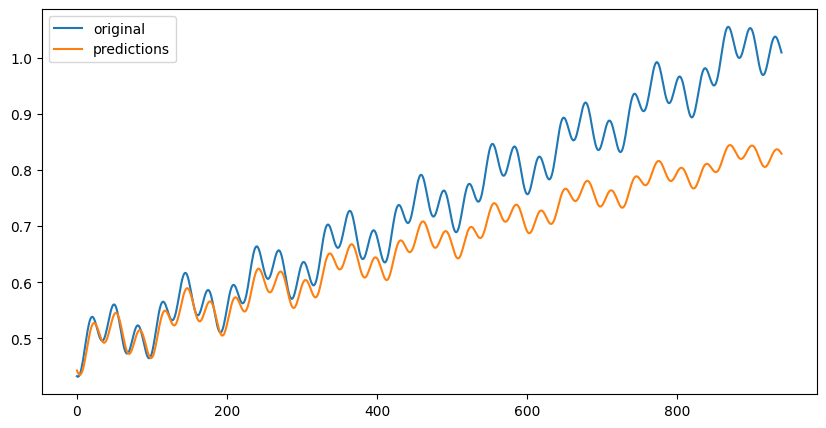

In [32]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label="original")
plt.plot(test_preds.squeeze().cpu().numpy(), label="predictions")
plt.legend()
plt.show()

## Long Shor Term Memory Networks (LSTM): Czy możemy jakoś rozdzielić krótką i długą pamięć?
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

![LSTM](https://cdn-images-1.medium.com/max/1000/1*Ht2-sUJHi65wDwnR276k3A.png)

In [33]:
sequence_length = 5
batch_size = 3
lstm = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(NUM_LAYERS, batch_size, HIDDEN_SIZE)
cell_state_0 = torch.randn(NUM_LAYERS, batch_size, HIDDEN_SIZE)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [34]:
print(output.shape)  # seq_len, batch_size, hidden_size
# containing the output features (h_t) from the last layer of the LSTM, for each t

torch.Size([5, 3, 5])


In [35]:
print(hn.shape)  # num_layers, batch_size, hidden_size
# containing the final hidden state for each element in the sequence

torch.Size([1, 3, 5])


In [36]:
print(cn.shape)  # num_layers, batch_size, hidden_size
# containing the final cell state for each element in the sequence


torch.Size([1, 3, 5])


In [37]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_size, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        out = all_outputs[-1]  # We are interested only in the last output
        x = self.fc(out)
        return x, hidden


model = LSTMRegressor(1, HIDDEN_SIZE, NUM_LAYERS, 1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 5)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, last_hidden = model(x, (hidden, state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0657
Epoch: 10, loss: 0.00342
Epoch: 20, loss: 0.00102
Epoch: 30, loss: 0.000719
Epoch: 40, loss: 0.000598
Epoch: 50, loss: 0.000486
Epoch: 60, loss: 0.000295
Epoch: 70, loss: 0.000133
Epoch: 80, loss: 6.43e-05
Epoch: 90, loss: 3.35e-05
Epoch: 100, loss: 1.52e-05


In [39]:
with torch.no_grad():
    hidden, state = model.init_hidden(test_data.size(0))
    hidden, state = hidden.to(device), state.to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2), (hidden, state))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean().item())

0.06443171948194504


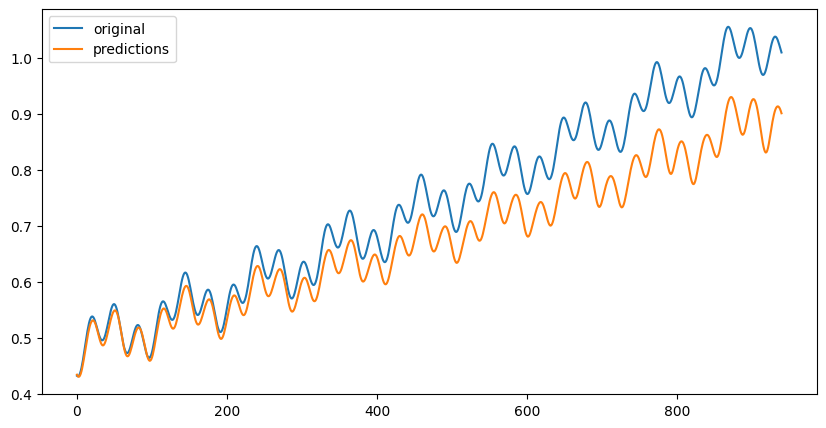

In [40]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label="original")
plt.plot(test_preds.squeeze().cpu().numpy(), label="predictions")
plt.legend()
plt.show()

### Mini zadanie: Jak wyglądałyby predykcje w oparciu o poprzednie predykcje?

In [45]:
with torch.no_grad():
    hidden, state = model.init_hidden(1)
    hidden, state = hidden.to(device), state.to(device)
    hidden = (hidden, state)
    ### UZUPEŁNIJ ###
    x_one = test_targets[0:1].unsqueeze(0).to(device)
    preds = []
    for i in range(len(test_targets)):
        x_one, hidden = model(x_one.unsqueeze(0), hidden)
        preds.append(x_one.item())

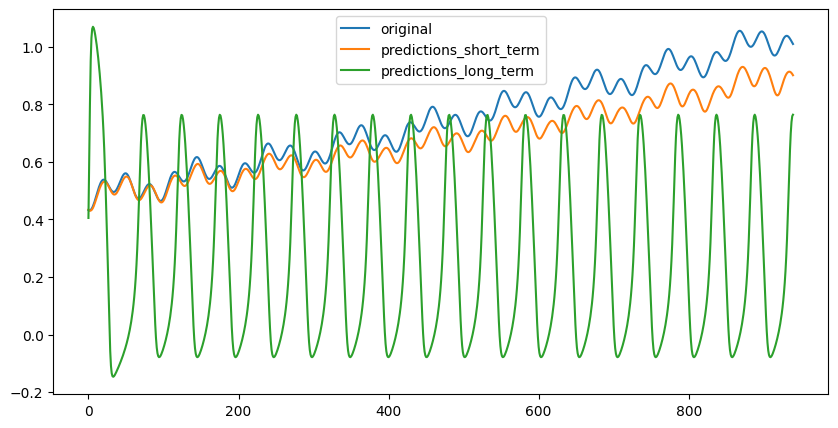

In [46]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label="original")
plt.plot(test_preds.squeeze().cpu().numpy(), label="predictions_short_term")
plt.plot(preds, label="predictions_long_term")
plt.legend()
plt.show()

# Predykcja Sequence to sequence

In [47]:
!wget --no-check-certificate https://www.galera.ii.pw.edu.pl/~kdeja/data/all_stocks_5yr.csv

--2025-05-09 07:13:13--  https://www.galera.ii.pw.edu.pl/~kdeja/data/all_stocks_5yr.csv
Resolving www.galera.ii.pw.edu.pl (www.galera.ii.pw.edu.pl)... 194.29.167.129
Connecting to www.galera.ii.pw.edu.pl (www.galera.ii.pw.edu.pl)|194.29.167.129|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/csv]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M  9.15MB/s    in 3.1s    

2025-05-09 07:13:17 (9.15 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [48]:
stock_price = pd.read_csv("all_stocks_5yr.csv")

In [49]:
mastercard_stock = stock_price[stock_price.Name == "MA"].open.values
visa_stock = stock_price[stock_price.Name == "V"].open.values

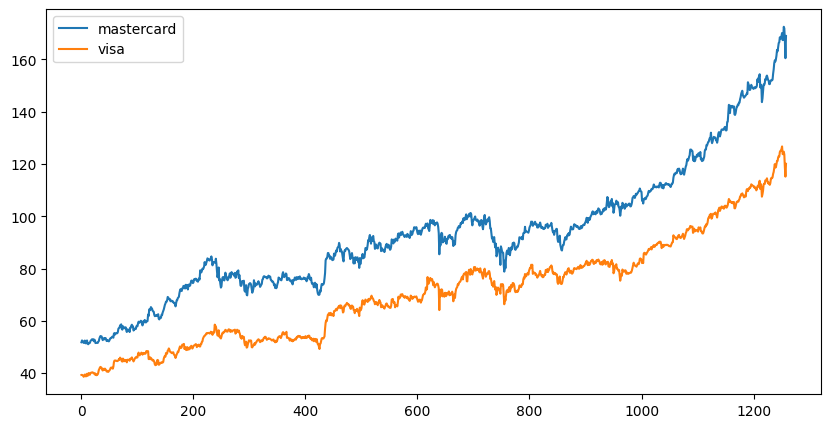

In [50]:
plt.figure(figsize=[10, 5])
plt.plot(mastercard_stock, label="mastercard")
plt.plot(visa_stock, label="visa")
plt.legend()
plt.show()

In [51]:
m_min_value = mastercard_stock.min()
m_max_value = mastercard_stock.max()
v_min_value = visa_stock.min()
v_max_value = visa_stock.max()

In [52]:
data_seq = []
data_targets = []
sequence_len = 50
for i in range(len(mastercard_stock) - sequence_len):
    data_seq.append(torch.from_numpy(mastercard_stock[i : i + sequence_len]))
    data_targets.append(torch.from_numpy(visa_stock[i : i + sequence_len]))

data = (torch.stack(data_seq).float() - m_min_value) / m_max_value
data_targets = (torch.stack(data_targets).float() - v_min_value) / v_max_value

train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(
    data[:train_split], data_targets[:train_split]
)
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
train_set = torch.utils.data.TensorDataset(
    data[:train_split], data_targets[:train_split]
)
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [53]:
class LSTM_Seq_Regressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            proj_size=out_size, # zamiast warstwy liniowej predykującej wynik
        )

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        return all_outputs, hidden


model = LSTM_Seq_Regressor(1, 50, 1, 1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 50, proj_size=1)
)

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, last_hidden = model(x, (hidden, state))
        preds = preds.squeeze(2)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0194
Epoch: 10, loss: 0.0107
Epoch: 20, loss: 0.00364
Epoch: 30, loss: 0.00341
Epoch: 40, loss: 0.00323
Epoch: 50, loss: 0.0031
Epoch: 60, loss: 0.00299
Epoch: 70, loss: 0.0029
Epoch: 80, loss: 0.00282
Epoch: 90, loss: 0.00275
Epoch: 100, loss: 0.00269


In [55]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    for i in range(0, len(test_targets), sequence_len):
        hidden, state = model.init_hidden(1)
        hidden, state = hidden.to(device), state.to(device)
        selected_test_targets.append(test_targets[i])
        pred, _ = model(
            test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state)
        )
        preds.append(pred.squeeze())

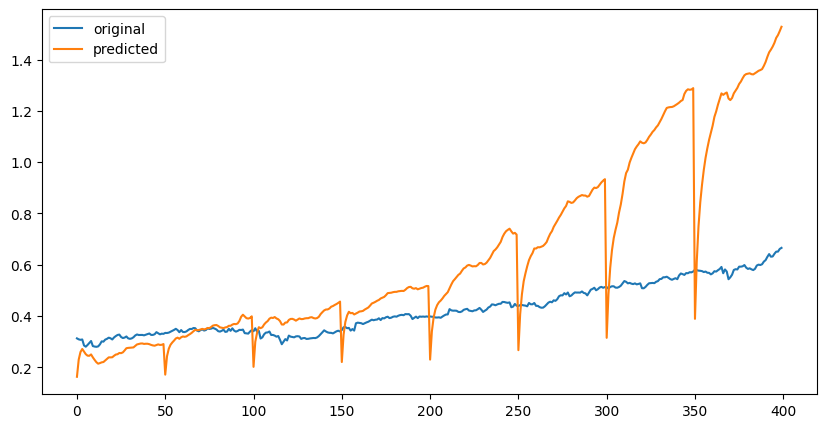

In [56]:
plt.figure(figsize=[10, 5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label="original")
plt.plot(torch.cat(preds).cpu().numpy(), label="predicted")
plt.legend()
plt.show() # Problem inicjujemy w każdej iteracji hidden na 0 zamiast przekazywać informacje

### Co się stało, skąd takie dziwne predykcje?

In [57]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    hidden, state = model.init_hidden(1)
    hidden, state = hidden.to(device), state.to(device)
    for i in range(0, len(test_targets), sequence_len):
        selected_test_targets.append(test_targets[i])
        pred, hidden_out = model(
            test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state)
        )
        hidden, state = hidden_out
        preds.append(pred.squeeze())

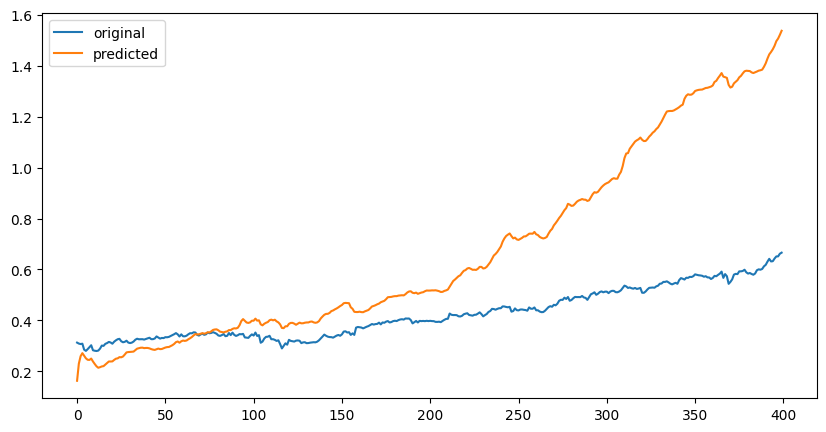

In [58]:
plt.figure(figsize=[10, 5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label="original")
plt.plot(torch.cat(preds).cpu().numpy(), label="predicted")
plt.legend()
plt.show()

# Klasyfikacja serii

In [59]:
libras = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data",
    header=None,
)

In [60]:
libras.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.79691,0.38194,0.79691,0.37731,0.79884,0.37731,0.79497,0.37731,0.77563,0.35417,...,0.51389,0.39845,0.42593,0.47389,0.36111,0.55899,0.31250,0.63830,0.29398,1
1,0.67892,0.27315,0.68085,0.27315,0.68085,0.27315,0.68085,0.27315,0.67892,0.26852,...,0.57407,0.17795,0.63657,0.17215,0.67361,0.17021,0.69213,0.17215,0.69213,1
2,0.72147,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,...,0.30556,0.59768,0.25926,0.67118,0.25231,0.73501,0.26620,0.78143,0.27778,1
3,0.56480,0.32407,0.56286,0.32407,0.56093,0.32407,0.55899,0.32407,0.55899,0.32407,...,0.49074,0.26306,0.42361,0.33269,0.34722,0.41006,0.28009,0.49130,0.24306,1
4,0.67118,0.38426,0.67118,0.38657,0.67311,0.38657,0.67311,0.38426,0.67311,0.37963,...,0.76389,0.44101,0.64120,0.45068,0.54167,0.47776,0.44213,0.53191,0.34259,1


In [61]:
classes = libras[90].values
data = libras.values[:, :-1]

In [62]:
data = torch.from_numpy(data).float()
data_targets = torch.from_numpy(classes).long()

train_indices = rng.random(len(data)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(
    data[train_indices], data_targets[train_indices]
)
train_loader = DataLoader(train_set, batch_size=32)
test_data, test_targets = data[test_indices], data_targets[test_indices]

### Napisz klasyfikator

In [65]:
class LSTMRegressor(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, out_size, bidirectional=False
    ):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.fc = nn.Linear(hidden_size * 90 * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        ### TODO ###
        hidden = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size # bidirectional bo dwukierunkowy LSTM (dodanie kierunku wstecz)
        )
        state = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, hidden):
        ### TODO ###
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        out = torch.flatten(all_outputs, 1)
        x = self.fc(out)
        return x, hidden


model = LSTMRegressor(1, 5, 2, 16, bidirectional=False).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 5, num_layers=2)
  (fc): Linear(in_features=450, out_features=16, bias=True)
)

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden, state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 2.98
Epoch: 10, loss: 2.01
Epoch: 20, loss: 1.9
Epoch: 30, loss: 1.63
Epoch: 40, loss: 0.928
Epoch: 50, loss: 0.734
Epoch: 60, loss: 0.617
Epoch: 70, loss: 0.546
Epoch: 80, loss: 0.501
Epoch: 90, loss: 0.467
Epoch: 100, loss: 0.439


In [67]:
with torch.no_grad():
    hidden, state = model.init_hidden(len(test_data))
    hidden, state = hidden.to(device), state.to(device)
    preds, _ = model(test_data.to(device).unsqueeze(2), (hidden, state))
print(
    f"Accuracy: {(torch.argmax(preds, 1).cpu() == test_targets).sum().item() / len(test_targets):.3}"
)

Accuracy: 0.24


# Dane o różnej długości

In [68]:
from torch.utils.data import Dataset # W skrócie padding


class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [69]:
min_gen_val = 10
max_gen_val = 1001
samples = 1000
max_gen_len = 32

data = []
targets = []
max_val = -1
for _ in range(samples):
    seq_len = rng.integers(low=1, high=max_gen_len, size=1) # Pewne randomowe sekwencje (jest to nieistotne)
    data_in = rng.integers(low=min_gen_val, high=max_gen_val, size=seq_len)
    data_sum = np.array([data_in[: i + 1].sum() for i in range(len(data_in))])
    data.append(torch.from_numpy(data_in))
    targets.append(torch.from_numpy(data_sum))
    max_val = data_sum[-1] if data_sum[-1] > max_val else max_val

In [70]:
[len(x) for x in data[:10]]

[28, 13, 28, 17, 7, 1, 6, 15, 27, 20]

In [71]:
train_indices = int(len(data) * 0.7)
data = [(x / max_val).float() for x in data]
targets = [(x / max_val).float() for x in targets]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(data[train_indices:], targets[train_indices:])

In [72]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

pad = 0


def pad_collate(batch, pad_value=0): # customowa funkcja batchująca
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [73]:
train_loader = DataLoader(
    train_set, batch_size=50, shuffle=True, collate_fn=pad_collate
)
test_loader = DataLoader(
    test_set, batch_size=50, shuffle=False, drop_last=False, collate_fn=pad_collate
)

In [74]:
next(iter(train_loader))

(tensor([[0.0408, 0.0398, 0.0037,  ..., 0.0000, 0.0000, 0.0000],
         [0.0167, 0.0080, 0.0029,  ..., 0.0000, 0.0000, 0.0000],
         [0.0313, 0.0173, 0.0036,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0236, 0.0308, 0.0119,  ..., 0.0000, 0.0000, 0.0000],
         [0.0180, 0.0273, 0.0425,  ..., 0.0504, 0.0307, 0.0410],
         [0.0167, 0.0225, 0.0530,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0408, 0.0806, 0.0844,  ..., 0.0000, 0.0000, 0.0000],
         [0.0167, 0.0247, 0.0276,  ..., 0.0000, 0.0000, 0.0000],
         [0.0313, 0.0486, 0.0522,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0236, 0.0544, 0.0663,  ..., 0.0000, 0.0000, 0.0000],
         [0.0180, 0.0453, 0.0878,  ..., 0.7619, 0.7926, 0.8335],
         [0.0167, 0.0392, 0.0922,  ..., 0.0000, 0.0000, 0.0000]]),
 [14,
  19,
  10,
  30,
  25,
  8,
  27,
  11,
  19,
  3,
  12,
  12,
  5,
  3,
  6,
  27,
  1,
  28,
  27,
  30,
  24,
  8,
  29,
  11,
  22,
  30,
  14,
  2,
  9,
  1,
  7,
  3,
  4,
  1

In [75]:
class LSTM_Seq_Regressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            proj_size=out_size,
        )

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        # x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        # all_outputs = torch.transpose(all_outputs, 0, 1)
        return all_outputs, hidden


model = LSTM_Seq_Regressor(1, 200, 1, 1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 200, proj_size=1)
)

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)

        x = torch.transpose(x, 0, 1)
        preds, _ = model(x, (hidden, state))
        preds = torch.transpose(preds, 0, 1)

        #         x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        #         preds_packed, _ = model(x_packed, (hidden, state))
        #         preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)

        preds = preds.squeeze(2)
        optimizer.zero_grad()
        mask = targets != pad
        loss = loss_fun(preds[mask], targets[mask])
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0508
Epoch: 10, loss: 0.00316
Epoch: 20, loss: 0.00212
Epoch: 30, loss: 0.00117
Epoch: 40, loss: 0.000618
Epoch: 50, loss: 0.000557
Epoch: 60, loss: 0.00032
Epoch: 70, loss: 0.000134
Epoch: 80, loss: 5.36e-05
Epoch: 90, loss: 2.97e-05
Epoch: 100, loss: 8.97e-06


In [77]:
with torch.no_grad():
    for x, targets, x_len, target_len in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.shape[0])
        hidden, state = hidden.to(device), state.to(device)

        #         x = torch.transpose(x, 0, 1)
        #         preds, _ = model(x, (hidden, state))
        #         preds = torch.transpose(preds, 0, 1)
        x_packed = pack_padded_sequence(
            x, x_len, batch_first=True, enforce_sorted=False
        )
        preds_packed, _ = model(x_packed, (hidden, state))
        preds, pred_len = pad_packed_sequence(
            preds_packed, batch_first=True, padding_value=pad
        )

        preds = preds.squeeze(2)
        mask_tgt = targets != pad

Jeśli chcemy wykorzystać ostatnie stany ukryte komórki, np. do klasyfikacji, naley wykorzystać `pack_padded_sequence`.
Dane nadal pozostaną w odpowiednim formacie, ale RNN nie będzie uwzględniał paddingu (jeśli tego nie zrobimy, RNN zwróci stany ukryty odpowiadający paddingowi, co jest niepozadane).   